# take2

**GOAL**: Keep It Stupid Simple = KISS.

**References**:
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control2

In [2]:
import functools
import itertools

import numpy as np
import matplotlib.pyplot as plt
import torch

from decentralized import control2
import pocketknives

In [3]:
%matplotlib widget
plt.rcParams['axes.grid'] = True

<Figure size 640x480 with 0 Axes>

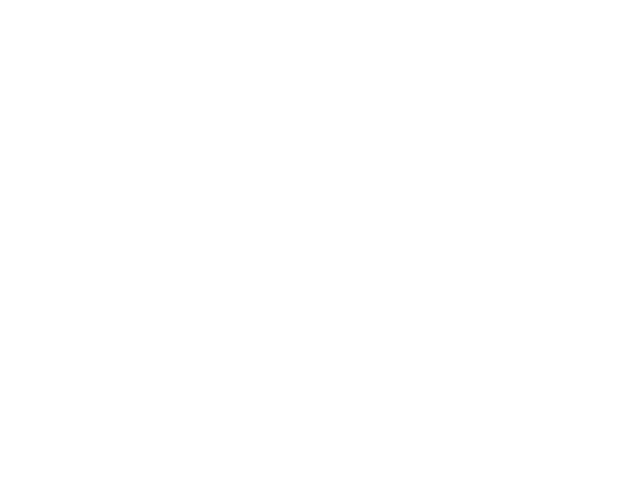

In [4]:
plt.figure()

In [37]:
def split_agents(Z, z_dims):
    """Partition a cartesian product state or control for individual agents"""
    if torch.is_tensor(Z):
        return torch.split(torch.atleast_2d(Z), z_dims, dim=1)
    return np.split(np.atleast_2d(Z), np.cumsum(z_dims[:-1]), axis=1)

In [21]:
def plot_solve(X, J, x_goal, x_dims=None):
    """Plot the resultant trajectory on plt.gcf()"""

    plt.clf()
    
    if not x_dims:
        x_dims = [X.shape[1]]
        
    N = X.shape[0]
    t = np.arange(N) * dt
    
    X_split = split_agents(X, x_dims)
    x_goal_split = split_agents(x_goal.reshape(1,-1), x_dims)
    
    for Xi, xg in zip(X_split, x_goal_split):
        plt.scatter(Xi[:,0], Xi[:,1], c=t)
        plt.scatter(Xi[0,0], Xi[0,1], 80, 'g', 'x', label="$x_0$")
        plt.scatter(xg[0,0], xg[0,1], 80, 'r', 'x', label="$x_f$")
    
    plt.margins(0.1)
    plt.title(f"Final Cost: {J:.3g}")

## single-agent problem

In [18]:
def unicycle_continuous(x, u):
    """
    Compute the time derivative of state for a particular state/control.
    NOTE: `x` and `u` should be 2D (i.e. column vectors).
    REF: [1]
    """
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)

    x_dot = torch.zeros(x.numel())
    x_dot[0] = x[3] * torch.cos(x[2])
    x_dot[1] = x[3] * torch.sin(x[2])
    x_dot[2] = u[0]
    x_dot[3] = u[1]
    return x_dot

In [19]:
def reference_cost(x, u, _x_goal, _Q, _R, _Qf=None, terminal=False):
    """Cost of reaching the goal"""
    
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)
    x = x.reshape(-1,1)
    u = u.reshape(-1,1)
    
    if _Qf is None:
        _Qf = torch.eye(Q.shape[0])
    
    if terminal:
        return (x - _x_goal).T @ _Qf @ (x - _x_goal)
    return (x - _x_goal).T @ _Q @ (x - _x_goal) + u.T @ _R @ u

In [20]:
dt = 0.1
N = 50

x = torch.tensor([-10, 10, 0, 0], dtype=torch.float, requires_grad=True)
x_goal = torch.zeros((4, 1), dtype=torch.float)

Q = torch.diag(torch.tensor([1., 1, 0, 0]))
Qf = 1000 * torch.eye(Q.shape[0])
R = torch.eye(2)
goal_cost = functools.partial(reference_cost, _x_goal=x_goal, _Q=Q, _R=R, _Qf=Qf)

ilqr = control2.iLQR(unicycle_continuous, goal_cost, x.numel(), 2, dt, N)
X, U, J = ilqr.solve(x)
plot_solve(X, J, x_goal.numpy())

0/50	J: 209874
1/50	J: 164786	μ: 0.5	Δ: 0.5
2/50	J: 141559	μ: 0.125	Δ: 0.25
3/50	J: 90773.6	μ: 0.015625	Δ: 0.125
4/50	J: 18300.8	μ: 0.000976562	Δ: 0.0625
5/50	J: 7564.6	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 6857.65	μ: 0	Δ: 0.015625
7/50	J: 4876.21	μ: 0	Δ: 0.0078125
8/50	J: 3525.38	μ: 0	Δ: 0.00390625
9/50	J: 3199.35	μ: 0	Δ: 0.00195312
10/50	J: 3128.1	μ: 0	Δ: 0.000976562
11/50	J: 3121.56	μ: 0	Δ: 0.000488281
12/50	J: 3094.7	μ: 0	Δ: 0.000244141
13/50	J: 3081.34	μ: 0	Δ: 0.00012207
14/50	J: 3075.38	μ: 0	Δ: 6.10352e-05


## multi-agent problem

In [48]:
def dynamics_nd(f, x, u, _x_dims, _u_dims):
    """Compute the continuous time derivative for n agents"""
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)
    return torch.cat([
        f(xi.flatten(), ui.flatten()) 
        for xi, ui in zip(split_agents(x, _x_dims), split_agents(u, _u_dims))
    ])

In [388]:
def proximity_cost(x, _x_dims, _radius):
    """Penalizes distances underneath some radius between agents"""
    assert len(set(_x_dims)) == 1

    assert torch.is_tensor(x)
    
    n_agents = len(_x_dims)
    n_states = _x_dims[0]

    pair_inds = torch.tensor(list(itertools.combinations(range(n_agents), 2)))
    x_agent = x.reshape(-1,n_agents,n_states).swapaxes(0,2)
    distances = torch.linalg.norm(x_agent[:2,pair_inds[:,0]] - x_agent[:2,pair_inds[:,1]], dim=0)

    pair_costs = torch.fmin(torch.zeros((1)), distances - _radius)**2
    return pair_costs.sum(dim=0)

In [390]:
def multi_agent_cost(goal_cost, prox_cost, x, u, terminal=False):
    """Reference deviation costs plus collision avoidance costs"""
    return goal_cost(x, u, terminal=terminal) + 50*prox_cost(x)

In [422]:
dt = 0.1
N = 60

x_dims = [4, 4]
u_dims = [2, 2]
x = torch.tensor([-5, -5, 0, 0,
                  -5,  5, 0, 0], 
                 dtype=torch.float, requires_grad=True)
x_goal = torch.tensor([[5,  5, 0, 0,
                        5, -4, 0, 0]],
                      dtype=torch.float).T

dynamics_8d = functools.partial(dynamics_nd, unicycle_continuous, _x_dims=x_dims, _u_dims=u_dims)

Q = torch.diag(torch.tensor([1., 1, 0, 0]).tile(2))
Qf = 1000 * torch.eye(Q.shape[0])
R = torch.eye(4)
radius = 0.5

goal_cost = functools.partial(reference_cost, _x_goal=x_goal, _Q=Q, _R=R, _Qf=Qf)
prox_cost = functools.partial(proximity_cost, _x_dims=x_dims, _radius=radius)
multi_cost = functools.partial(multi_agent_cost, goal_cost, prox_cost)

In [423]:
# %%prun
ilqr = control2.iLQR(dynamics_8d, multi_cost, x.numel(), 4, dt, N)
X, U, J = ilqr.solve(x)

0/50	J: 403517
1/50	J: 49171.9	μ: 0.5	Δ: 0.5
2/50	J: 28909.6	μ: 0.125	Δ: 0.25
3/50	J: 19468.6	μ: 0.015625	Δ: 0.125
4/50	J: 17903.5	μ: 0.000976562	Δ: 0.0625
5/50	J: 11103.3	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 7423.25	μ: 0	Δ: 0.015625
7/50	J: 6299.59	μ: 0	Δ: 0.0078125
8/50	J: 6242.5	μ: 0	Δ: 0.00390625
9/50	J: 5966.88	μ: 0	Δ: 0.00195312
10/50	J: 5893.41	μ: 0	Δ: 0.000976562
11/50	J: 5861.55	μ: 0	Δ: 0.000488281
12/50	J: 5848.98	μ: 0	Δ: 0.000244141
 

         943274 function calls (938528 primitive calls) in 15.159 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17290    7.026    0.000    7.026    0.000 {method 'run_backward' of 'torch._C._EngineBase' objects}
     8280    0.936    0.000    1.289    0.000 1703630234.py:1(unicycle_continuous)
    35495    0.703    0.000    0.703    0.000 {method 'reshape' of 'torch._C._TensorBase' objects}
     4209    0.474    0.000    0.567    0.000 2586921350.py:1(reference_cost)
     4209    0.470    0.000    1.016    0.000 482437832.py:1(proximity_cost)
       13    0.466    0.036   12.635    0.972 control2.py:153(_backward_pass)
    17290    0.402    0.000    0.402    0.000 {built-in method ones_like}
3159/2366    0.388    0.000   10.949    0.005 functional.py:484(jacobian)
     7904    0.279    0.000    0.279    0.000 {built-in method stack}
       42    0.274    0.007    1.867    0.044 control2.py:132(_forward_pass)
      780

In [411]:
plot_solve(X, J, x_goal.numpy(), [4, 4])

In [403]:
distances = np.linalg.norm(X[:,:2] - X[:,4:6], axis=1)
plt.clf()
plt.plot(distances)
plt.hlines(radius, *plt.xlim(), 'r')

In [398]:
costs = []
for xi, ui in zip(X, U):
    costs.append(multi_cost(torch.from_numpy(xi), torch.from_numpy(ui)).item())
plt.clf()
plt.plot(costs)